# Illustration of datascience Tables for multivariate analysis

**David E. Culler**

This notebook illustrates some of the use of datascience Tables to perform regressions on multiple variables. In doing so, it shows some of the elegant ways that computational concepts and statistical concepts naturally fit together.

In [3]:
# HIDDEN
from datascience import *
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

## Read data from a local or remote csv file to create a Table

In [4]:
# Source https://onlinecourses.science.psu.edu/stat501/node/380
births=Table.read_table("data/birthsmokers.csv")
births

Wgt,Gest,Smoke
2940,38,1
3130,38,0
2420,36,1
2450,34,0
2760,39,1
2440,35,1
3226,40,0
3301,42,1
2729,37,0
3410,40,0


## Looking at the raw data

`Table.scatter` produces a scatter plot of columns versus a specific column.  Here we look at how birthweight varies with gestation. And we note whether the mother smoked.

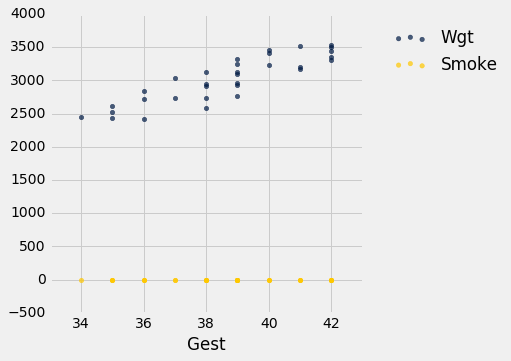

In [5]:
# First let's just look at what is here.  This needs to be a scatter, rather
# than a plot because there is no simple ordering - just relationships between
# birthweight and gestation time along with whether the mother smokes.
births.scatter('Gest')

In [6]:
births.num_rows

32

In [7]:
# How many samples in each category
births.where('Smoke').num_rows

16

## Fitting a line to the data on a scatter plot

Here we drop the `smoke` column and look at the birthweight for the whole population.

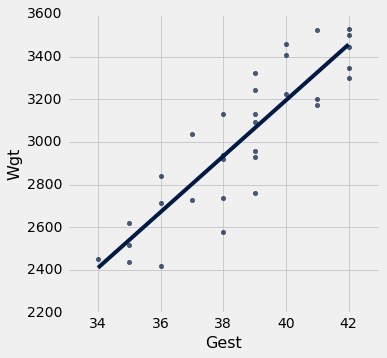

In [8]:
# As there is a trend among birthweight and gestation, we can show a fit line to try to
# capture it
births.drop('Smoke').scatter('Gest', fit_line=True)

## Partitioning data

The question is whether smoking causes the trend to be substantially different.
Split the data into two tables using the `Smoke` column.  Then we can find the trends for each.

In [9]:
nosmoke=births.where('Smoke',0).drop('Smoke')
smoke=births.where('Smoke',1).drop('Smoke')

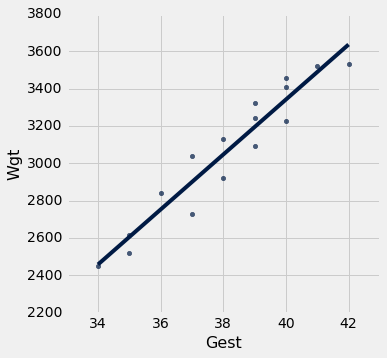

In [10]:
# we can attempt to find the trend for each
nosmoke.scatter('Gest',fit_line=True)

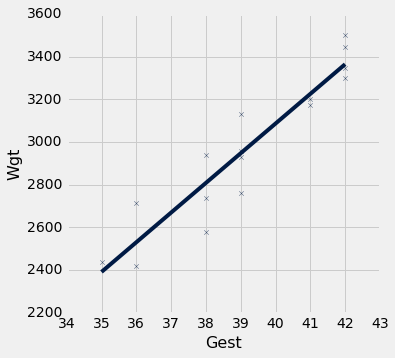

In [11]:
smoke.scatter('Gest',fit_line=True, marker='x')

## Build a model by fitting a line to data in a Table

Selecting a column of a Table yields a numpy array, allowing the numpy numerical
tools to be used for fitting curves to the data.  For documentation on the `polyfit` 
function, try `help(np.polyfit)`.  It returns the polynomial coefficients, highest power first, which is the slope for a line.

A linear model is only meaningful in the range around the normal gestation period,
and indeed the intercept is not physcially meaningful

In [12]:
# what is the coeeficients of the line fitted to these data?

np.polyfit(nosmoke['Gest'],nosmoke['Wgt'],1)

array([  147.20689655, -2546.13793103])

In [13]:
np.polyfit(smoke['Gest'],smoke['Wgt'],1)

array([  139.02874903, -2474.56410256])

We see that both the constant and the weight increase per week is lower for the smokers.

## Higher order functions as models

At this point, we could do mx+b all over the place, or we could utilize **higher order functions** to capture the concept of a model.  Here is an example, building such a model directly from the data.  It takes the set of `x` and `y` values and returns a function
that evaluates the model built from that data at a particular `x`.

In [14]:
# Build a linear model from data and return it is a function
def make_lm(x, y):
    m,b = np.polyfit(x, y, 1)
    def lm(a):
        return m*a+b
    return lm 

In [15]:
# Create model of non-smokers that returns estimated weight a function of weeks gestation
nosmoker_weight = make_lm(nosmoke['Gest'], nosmoke['Wgt'])

In [16]:
# Evaluate it at normal gestations
nosmoker_weight(40)

3342.1379310344846

In [17]:
smoker_weight = make_lm(smoke['Gest'], smoke['Wgt'])

In [18]:
smoker_weight(40)

3086.5858585858577

## Drawing a conclusion 

Using the models to remove the contribution due to gestation time, we can attempt to draw a conclusion about the effect of smoking at typical gestation age.

In [19]:
# based on this data set, fitting the data to models of weight as a function of gestation
# We might conclude that at 40 weeks the effect of smoking on birthweigth in grams is
smoke_diff = nosmoker_weight(40) - smoker_weight(40)
smoke_diff

255.55207244862686

In [20]:
# Or in relative terms
"{0:.1f}%".format(100*(nosmoker_weight(40)-smoker_weight(40))/nosmoker_weight(40))

'7.6%'

## Use the models to build a Table and visualize the effect of the categorical parameter - smoking

In [21]:
# Create a table with a column containing the independent variable
estimated_birthweight = Table().with_column('week', np.arange(32,44))
# Add columns of dependent variables
estimated_birthweight['nosmoke'] = estimated_birthweight.apply(nosmoker_weight,'week')
estimated_birthweight['smoke'] = estimated_birthweight.apply(smoker_weight,'week')
estimated_birthweight

week,nosmoke,smoke
32,2164.48,1974.36
33,2311.69,2113.38
34,2458.9,2252.41
35,2606.1,2391.44
36,2753.31,2530.47
37,2900.52,2669.5
38,3047.72,2808.53
39,3194.93,2947.56
40,3342.14,3086.59
41,3489.34,3225.61


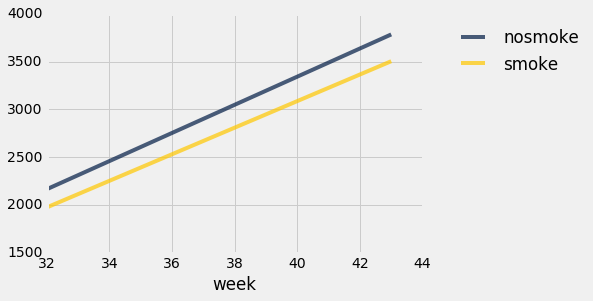

In [22]:
# plot it to visualize
estimated_birthweight.plot('week',overlay=True)

## Determining if the conclusion is sound

At this point, we might ask how accurately these linear models fit the data.  The 'residual' in the fit would give us some idea of this.  But the error in summarizing a collection of empirical data with an analytical model is only a part of the question.  

The deeper point is that this data is not "truth", it is merely a sample of a population, and a tiny one at that.  We should be asking, is an inference drawn from this data valid for the population that the data is intended to represent.  Of course, the population is not directly observable, only the sample of it.  How can we use the sample we have to get some idea of how representative it is of the larger population.  That is what bootstrap seeks to accomplish.

Tables provide a method `sample` for just this purpose.  Here we return to looking at
the coefficients, rather than build a function for the model.

In [23]:
# Construct a new model by forming a new sample from our existing one and fiting a line to that
# Here we create quite a general function, which takes a table and column names over which
# the model is to be formed.  
def rboot(table, x, y):
    sample = table.sample(table.num_rows, with_replacement=True)
    return np.polyfit(sample[x],sample[y],1)

In [24]:
# Try it out for non-smokers.  Note that every time this cell is evaluated (ctrl-enter)
# the result is a little different, since a new sample is drawn.
rboot(nosmoke, 'Gest', 'Wgt')

array([  164.26388889, -3203.14583333])

In [25]:
# And for smokers
rboot(smoke,'Gest','Wgt')

array([  138.46774194, -2468.50806452])

## Bootstrap

Using this model builder as a function, draw many samples and form a model for each.  
Then we can look at the distribution of the model parameters over lots of models.

This illustrates the construction of tables by rows.  The Table constructor accepts the 
column names and `with_rows` fills them in row by row.

`hist` forms and shows a histogram of the result.

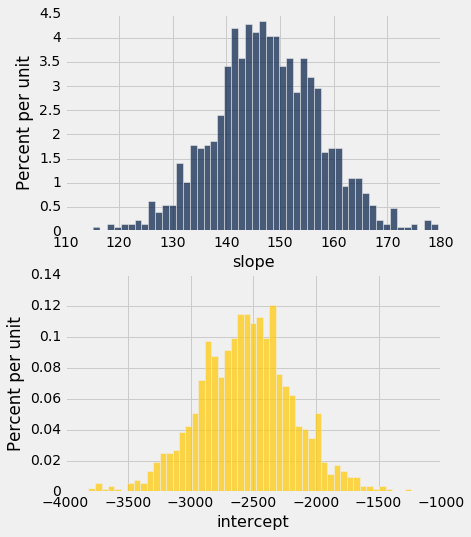

In [26]:
# Bootstrap a distribution of models by drawing many random samples, with replacement, from our samples
num_samples = 1000
nosamples = Table(['slope','intercept']).with_rows([rboot(nosmoke,'Gest','Wgt') for i in range(num_samples)])
nosamples.hist(bins=50,normed=True, overlay=False)

And we repeate this for the other category.

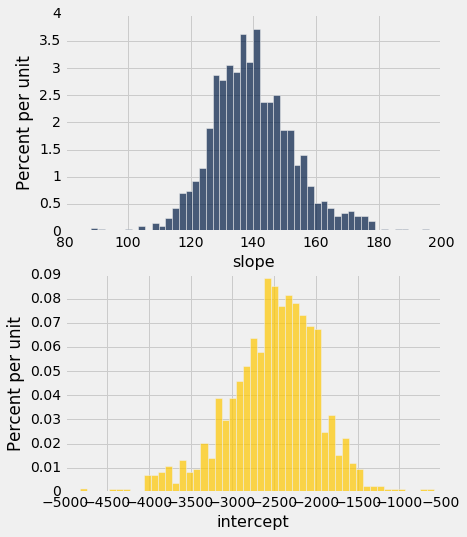

In [27]:
smokesamples = Table(['slope','intercept']).with_rows([rboot(smoke,'Gest','Wgt') for i in range(num_samples)])
smokesamples.hist(bins=50,normed=True, overlay=False)

## Summary of sample distributions of the regression

At this point we could compute a statistic over the sample distributions of these parameters, such as the total variational distance, or the mean.

In [28]:
nosamples.stats([np.min,np.mean,np.max])

statistic,slope,intercept
amin,115.182,-3814.18
mean,147.53,-2556.88
amax,179.448,-1237.52


In [29]:
smokesamples.stats([np.min,np.mean,np.max])

statistic,slope,intercept
amin,88.2447,-4820.81
mean,139.815,-2508.46
amax,196,-589.657


## Estimation of birthweights at 40 weeks

Selecting a column of a Table yields a numpy array.  Arithmetic operators work
elementwise on the entire array.

In [30]:
smokesamples['slope']*40+smokesamples['intercept']

array([ 3042.95149254,  3112.06811146,  3088.03921569,  3074.52740168,
        3097.85313531,  3072.14760148,  3070.93203181,  3046.54018445,
        3091.70460048,  3093.00762777,  3053.96825397,  3120.44646925,
        3085.02777778,  3082.42842843,  3122.50111857,  3112.85164835,
        3051.5572666 ,  3113.27892977,  3132.4546148 ,  3134.81023102,
        3072.63189093,  3109.0745098 ,  3083.01234568,  3088.57260726,
        3106.7652968 ,  3084.32237312,  3090.56628788,  3072.37733333,
        3054.70972222,  3097.01269841,  3066.01210898,  3070.85327924,
        3121.12681159,  3053.00757576,  3051.21326165,  3071.42556084,
        3079.7807971 ,  3049.87083333,  3074.06917543,  3131.01574803,
        3056.32230392,  3074.91666667,  3131.29546991,  3091.94089347,
        3138.13524937,  3039.70972222,  3133.85558354,  3085.60526316,
        3048.9380805 ,  3071.09302326,  3064.60703364,  3060.356974  ,
        3027.38797814,  3071.80500284,  3126.89369708,  3138.5862069 ,
      

In [31]:
# So now we have an estimate of the distribution of birthweights at week 40 for 
# something closer to the populations that these small samples represent.
weights_40 = Table().with_columns([
        ('nosmoke', nosamples['slope']*40+nosamples['intercept']),
        ('smoke', smokesamples['slope']*40+smokesamples['intercept'])])
weights_40

nosmoke,smoke
3335.95,3042.95
3400.74,3112.07
3301.64,3088.04
3343.92,3074.53
3374.81,3097.85
3329.85,3072.15
3328.49,3070.93
3371.23,3046.54
3357.23,3091.7
3331.11,3093.01


In [32]:
weights_40['Smoke Wgt Loss'] = weights_40['nosmoke'] - weights_40['smoke']

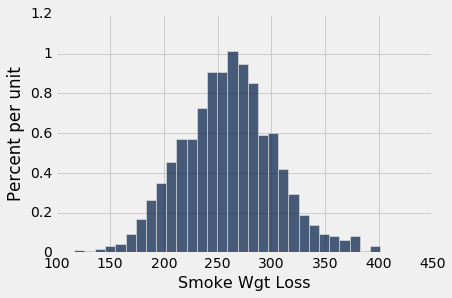

In [33]:
# what do we expect the distribution of birthweight reduction due to smoking to look like
# for the population represented by the original sample?
weights_40.select('Smoke Wgt Loss').hist(bins=30,normed=True)  

In [34]:
smoke_diff

255.55207244862686

In [35]:
def firstQtile(x) : return np.percentile(x,25)
def thirdQtile(x) : return np.percentile(x,25)
summary_ops = (min, firstQtile, np.median, np.mean, thirdQtile, max)

In [36]:
summary = weights_40.stats(summary_ops)
summary

statistic,nosmoke,smoke,Smoke Wgt Loss
min,3242.75,2940.13,116.965
firstQtile,3321.98,3065.69,231.516
median,3342.44,3084.41,260.932
mean,3344.3,3084.13,260.173
thirdQtile,3321.98,3065.69,231.516
max,3464.28,3170.71,401.404


In [37]:
summary['diff']=summary['nosmoke']-summary['smoke']

In [38]:
# the bottom line
summary

statistic,nosmoke,smoke,Smoke Wgt Loss,diff
min,3242.75,2940.13,116.965,302.617
firstQtile,3321.98,3065.69,231.516,256.29
median,3342.44,3084.41,260.932,258.029
mean,3344.3,3084.13,260.173,260.173
thirdQtile,3321.98,3065.69,231.516,256.29
max,3464.28,3170.71,401.404,293.573


## Visualizing the separation of these distributions

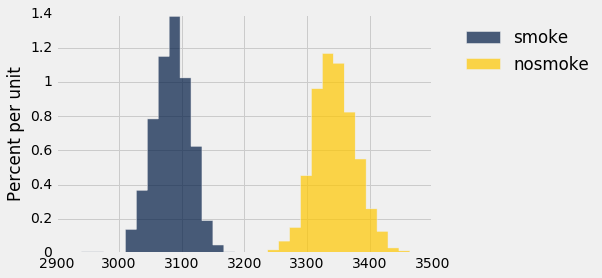

In [39]:
weights_40.select(['smoke','nosmoke']).hist(overlay=True,bins=30,normed=True)  

# Empirical p-values

A more formal approach would be to take as the null hypothesis that smoking does not affect the birthweight.  Repeatedly split the data into random halves and model the birthweight difference.  What is the chance that the difference we see in summary table is an artifact?

In [40]:
# As an example, split the original data into two random halves
A, B = births.split(births.num_rows//2)

In [41]:
A

Wgt,Gest,Smoke
3175,41,1
3459,40,0
2420,36,1
3040,37,0
2715,36,1
3322,39,0
2957,39,1
3244,39,0
2928,39,1
3095,39,0


In [42]:
B

Wgt,Gest,Smoke
3530,42,0
3130,39,1
2841,36,0
3446,42,1
2580,38,1
3410,40,0
2920,38,0
2760,39,1
3523,41,0
2740,38,1


In [43]:
make_lm(A['Gest'], A['Wgt'])(40)

3212.4761904761881

In [44]:
make_lm(B['Gest'], B['Wgt'])(40)

3174.8721804511288

## Capturing statistical computations and general tools

Rather than compute the null hypothesis for this particular table, we can build a very general tool, as a function, that will do it in general.

Then we can use it to build a sample distribution under the null hypothesis

In [45]:
def null_diff_at(tbl, x, y, w):
    A, B = tbl.split(tbl.num_rows//2)
    return make_lm(A[x], A[y])(w) - make_lm(B[x], B[y])(w)

In [46]:
null_diff_at(births, 'Gest', 'Wgt', 40)

21.556415688831294

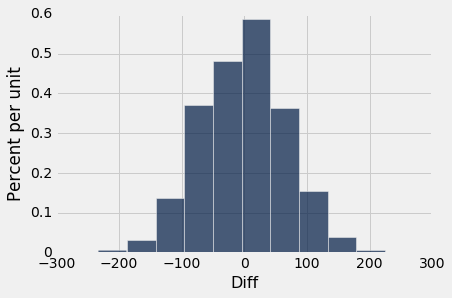

In [47]:
null = Table().with_column('Diff', [null_diff_at(births, 'Gest', 'Wgt', 40) for i in range(1000)])
null.hist()

What is the probablility that we got a 260g difference in birthweight at 40 weeks as an artifact of the sample?

Zero

In [48]:
null.stats()

statistic,Diff
min,-233.477
max,224.563
median,1.10395
sum,-1725.1
